Automating garment classification is the aim of this repo, pytorch's CNN model was implemented for image classification to automatically categorize new clothing listings, making it easier for a person, customer to find what they're looking for. This will assist in inventory management by quickly sorting items. The primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
from tqdm import tqdm

loading the data using torch's datasets module

In [3]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Checking the image data

In [4]:
import matplotlib.pyplot as plt

In [5]:
image, label = next(iter(train_data))

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
num_classes = len(train_data.classes)
print(num_classes)

10


In [8]:
image_size = train_data[0][0].shape
image_size

torch.Size([1, 28, 28])

In [9]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

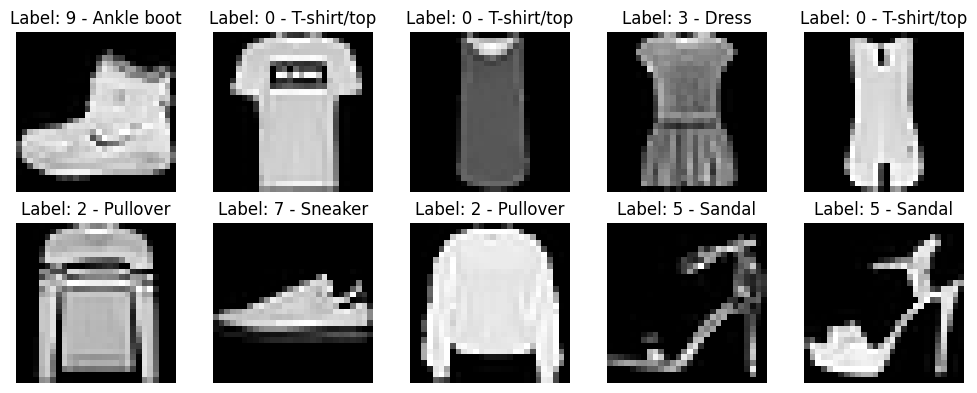

In [10]:
def view_first_10_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        image, label = dataset[i]
        axes[i//5, i%5].imshow(image.squeeze(), cmap='gray')
        axes[i//5, i%5].set_title(f'Label: {label} - {dataset.classes[label]}')
        axes[i//5, i%5].axis('off')
    plt.tight_layout()
    plt.show()

view_first_10_images(train_data)

In [11]:
len(train_data), len(test_data)

(60000, 10000)

above is a few sample of clothings of some lables

Text(0.5, 1.0, '9 - Ankle boot')

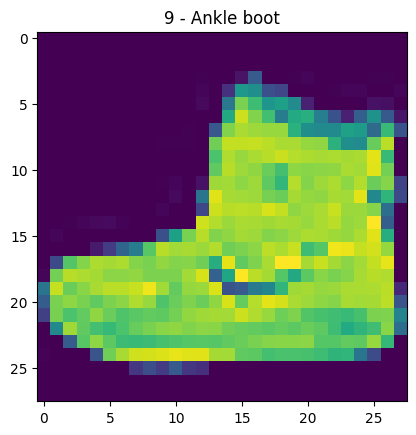

In [12]:
plt.imshow(image.squeeze())
plt.title(f'{label} - {train_data.classes[label]}')

In [13]:
type(label)

int

model development stage

The Net class is a simple CNN that consists of two convolutional layers followed by max pooling, a flattening layer, and a fully connected layer for classification. The forward method defines how the input data passes through these layers to produce output class probabilities.

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(16* 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.classifier(x)
        x = nn.functional.softmax(x)
        return x

model = Net(num_classes)

In [15]:
model

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

initializing the optimizer, loss function

In [50]:

from torch.nn import CrossEntropyLoss
criterion = CrossEntropyLoss()

In [66]:
def run_model(data_file):
    rate = [0.001, 0.005, 0.01, 0.05, 0.1]
    for lr in rate:
        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = .0004)
        losses = []
        for epoch in tqdm(range(5)):
            for image, label in data_file:
                label, image = torch.tensor(label), torch.tensor(image)
                #label = label.unsqueeze(0)
                optimizer.zero_grad()
                #forward pass
                outputs = model(image)
                loss = criterion(outputs, label)
                #back pass
                loss.backward()
                #update parameters
                optimizer.step()
                losses.append(loss.item())

                
            print(f'the loss for epoch {epoch+1}: with {lr} = {loss.item():.4f}')

In [67]:
datafor_train = DataLoader(train_data, batch_size= 8, shuffle=True)

In [68]:
model.train()
run_model(datafor_train)



C:\Users\Abdullahi Mujaheed\AppData\Local\Temp\ipykernel_19636\2012721818.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label, image = torch.tensor(label), torch.tensor(image)
C:\Users\Abdullahi Mujaheed\AppData\Local\Temp\ipykernel_19636\3515683998.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)




the loss for epoch 1: with 0.001 = 2.3362


the loss for epoch 2: with 0.001 = 1.8362


the loss for epoch 3: with 0.001 = 2.2095


the loss for epoch 4: with 0.001 = 1.9540




100%|██████████| 5/5 [06:03<00:00, 72.71s/it]


the loss for epoch 5: with 0.001 = 1.9561


the loss for epoch 1: with 0.005 = 1.5860


the loss for epoch 2: with 0.005 = 1.6656


the loss for epoch 3: with 0.005 = 1.6628


the loss for epoch 4: with 0.005 = 1.4677




100%|██████████| 5/5 [06:50<00:00, 82.18s/it]


the loss for epoch 5: with 0.005 = 1.5897


the loss for epoch 1: with 0.01 = 1.6343


the loss for epoch 2: with 0.01 = 1.5091


the loss for epoch 3: with 0.01 = 1.7825


the loss for epoch 4: with 0.01 = 1.8469




100%|██████████| 5/5 [06:50<00:00, 82.02s/it]


the loss for epoch 5: with 0.01 = 1.6094


the loss for epoch 1: with 0.05 = 2.3027


the loss for epoch 2: with 0.05 = 2.3362


the loss for epoch 3: with 0.05 = 2.2743


the loss for epoch 4: with 0.05 = 2.2112




100%|██████████| 5/5 [06:09<00:00, 73.98s/it]


the loss for epoch 5: with 0.05 = 2.3165


the loss for epoch 1: with 0.1 = 2.4541


the loss for epoch 2: with 0.1 = 2.3362


the loss for epoch 3: with 0.1 = 2.3124


the loss for epoch 4: with 0.1 = 2.4611




100%|██████████| 5/5 [07:02<00:00, 84.56s/it]

the loss for epoch 5: with 0.1 = 2.2109


the learning rate 0.05 yielded better losses

In [54]:
'''model.train()
for lr in [0.02, 0.04, 0.06, 0.08, 0.1]:
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = .0004)
    for epoch in tqdm(range(2)):
        model_x = tqdm(run_model(datafor_train))'''

'model.train()\nfor lr in [0.02, 0.04, 0.06, 0.08, 0.1]:\n    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = .0004)\n    for epoch in tqdm(range(2)):\n        model_x = tqdm(run_model(datafor_train))'

Testing the model on the test data

In [69]:
model.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

In [70]:
datafor_test = DataLoader(test_data, batch_size = 8, shuffle=False)

In [71]:
image, label = next(iter(test_data))

In [72]:
from torchmetrics import Accuracy, Recall, Precision

In [73]:
acc_metric = Accuracy(task= 'multiclass', num_classes= num_classes)
prec_metric = Precision(task = 'multiclass', num_classes= num_classes, average= 'macro')
recall_metric = Recall(task = 'multiclass', num_classes=num_classes)

In [75]:
def measure_metrics(test_file):
    predictions = []

    acc_metric.reset()
    prec_metric.reset()
    recall_metric.reset()

    with torch.no_grad():
        for image, label in tqdm(test_file): # adjust indexing if your DataLoader returns (inputs, labels)
            outputs = model.forward(image)
            predicted = torch.argmax(outputs, dim=1)
            predictions.append(predicted)
            acc_metric(predicted, label)
            prec_metric(predicted, label)
            recall_metric(predicted, label)
            
    # Compute metrics
    accuracy = acc_metric.compute().item()
    precision = prec_metric.compute().item()
    recall = recall_metric.compute().item()
    return accuracy, precision, recall, predictions

In [48]:
accuracy, precision, recall, predictions = measure_metrics(datafor_test)



C:\Users\Abdullahi Mujaheed\AppData\Local\Temp\ipykernel_19636\3515683998.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


















































































































































100%|██████████| 1250/1250 [00:08<00:00, 154.16it/s]


In [1]:
print(f'accuracy: {accuracy}, \n precision: {precision}, \n recall: {recall}')

NameError: name 'accuracy' is not defined

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
model.onnx.export

device(type='cpu')

In [16]:
from openvino import Core

In [18]:
Core().available_devices

['CPU', 'GPU']

In [23]:
model_dummy_input = torch.randn(8, 1, 28, 28)

In [25]:
model_onnx = torch.onnx.export(model, model_dummy_input, dynamo= True)

[torch.onnx] Obtain model graph for `Net([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Net([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


c:\Users\Abdullahi Mujaheed\Desktop\elevvo\elevvo-bootcamp\elevvo-venv\Lib\site-packages\torch\_export\non_strict_utils.py:1051: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [26]:
model_onnx.save("clothing_classifier.onnx")